# <a id='0'>Forecasting Chickenpox: Contents of Project</a>
- <a href='#1.0'>1. Setup</a>
- <a href='#2.0'>2. Data Import</a>
- <a href='#3.0'>3. Univariate Time Series</a>
    - <a href='#3.1'>3.1 Naive Forecast</a>
    - <a href='#3.2'>3.2 Exponential Smoothing</a>
    - <a href='#3.3'>3.3 STL Decomposition</a>
    - <a href='#3.4'>3.4 SARIMA</a>
    - <a href='#3.5'>3.5 Univariate Summary</a>
- <a href='#4.0'>4. Multivariate Time Series</a>
    - <a href='#4.1'>4.1 Naive Forecast</a>
    - <a href='#4.2'>4.2 Vector Autoregression (VAR)</a>
- <a href='#5.0'>5. Summary</a>
- <a href='#References'>References</a>

# <a id=1.0>1. Setup </a>

In [1]:
# Configuration
import sys
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.api import VAR
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
register_matplotlib_converters()
sns.set_style('darkgrid')

In [2]:
# My defined functions
if './functions/' not in sys.path:
    sys.path.append('./functions/')
import udf

In [3]:
# Global Variables
START = '2014-01-06'
END = '2014-12-29'
N_PERIODS = 52

# <a id='2.0'>2. Data Import</a>

In [4]:
dateparsefunc = lambda x: datetime.datetime.strptime(x, "%d/%m/%Y")
data_df = pd.read_csv('./input/hungary_chickenpox.csv',parse_dates=['Date'], index_col='Date', date_parser=dateparsefunc)
data_df.index.freq='W-MON'

In [5]:
data_df.shape

(522, 20)

In [6]:
data_df.head()

,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
Date,,,,,,,,,,,,,,,,,,,,
2005-01-03,168,79,30,173,169,42,136,120,162,36,130,57,2,178,66,64,11,29,87,68
2005-01-10,157,60,30,92,200,53,51,70,84,28,80,50,29,141,48,29,58,53,68,26
2005-01-17,96,44,31,86,93,30,93,84,191,51,64,46,4,157,33,33,24,18,62,44
2005-01-24,163,49,43,126,46,39,52,114,107,42,63,54,14,107,66,50,25,21,43,31
2005-01-31,122,78,53,87,103,34,95,131,172,40,61,49,11,124,63,56,7,47,85,60


In [7]:
# Null Values
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).T

,ZALA,VESZPREM,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,HEVES,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,BUDAPEST
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# <a id='3.0'>3. Univariate Time Series</a>

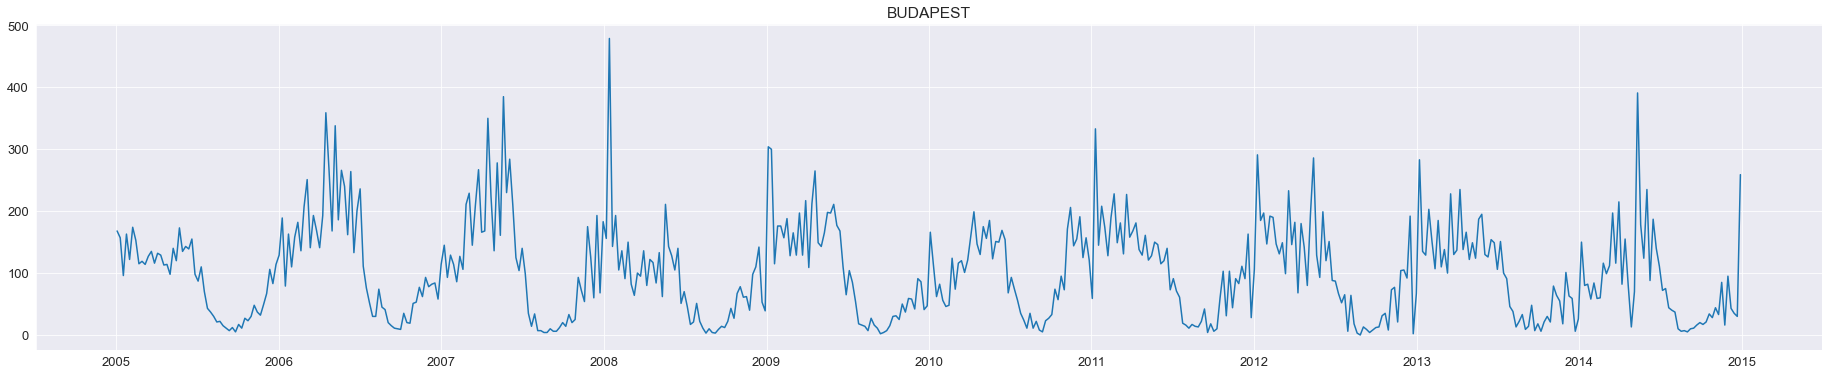

In [8]:
budapest = data_df['BUDAPEST']
plt.rc('figure',figsize=(32,6))
plt.rc('font',size=13)
plt.plot(budapest)
plt.title('BUDAPEST');

### Important Consideration

The data is count data (non-negative integers). Most forecasting methods assume a continuous input and so the data will be transformed (using log transformation, with a '+2' to take into consideration 0 counts) the resulting transform is >0. If '+1' then 0 could appear in the output (log(0+1)=0) which can mess with forecasting methods. log(0+2) > 0.

In [9]:
# #Transform
budapest = np.log(budapest+2)

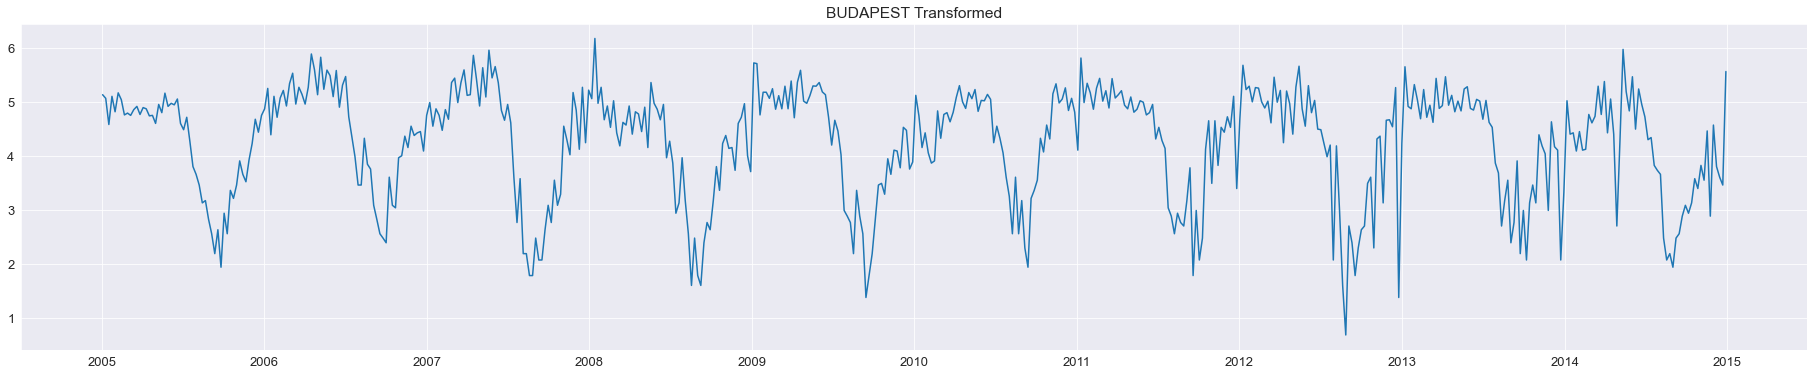

In [10]:
plt.rc('figure',figsize=(32,6))
plt.rc('font',size=13)
plt.plot(budapest)
plt.title('BUDAPEST Transformed');

In [11]:
# Split data into training and validation sets
train, val = udf.train_test_split(budapest, N_PERIODS)

## <a id='3.1'>3.1 Naive Forecast (Baseline)</a>

The naive forecast is called as such since it is a quick, heuristic, method to arrive at a forecast. Simply put, the naive forecast uses the values, or a moving average, to form the forecast values of the next period. It is surprisingly effective and has been estimated to beat more "complex" methods more than 50% of the time<sup>1</sup>. This will be used as the baseline model and all subsequent methods will be compared to the naive forecast's results, improvements over this baseline are considered "forecast value added".

In [12]:
model_name = 'Naive Forecast'
nv_predictions = train[-N_PERIODS:]

In [13]:
# Prediction Intervals
nv_fcst_mean, nv_fcst_min, nv_fcst_max = udf.nv_pred_intvl(nv_predictions, val, train)

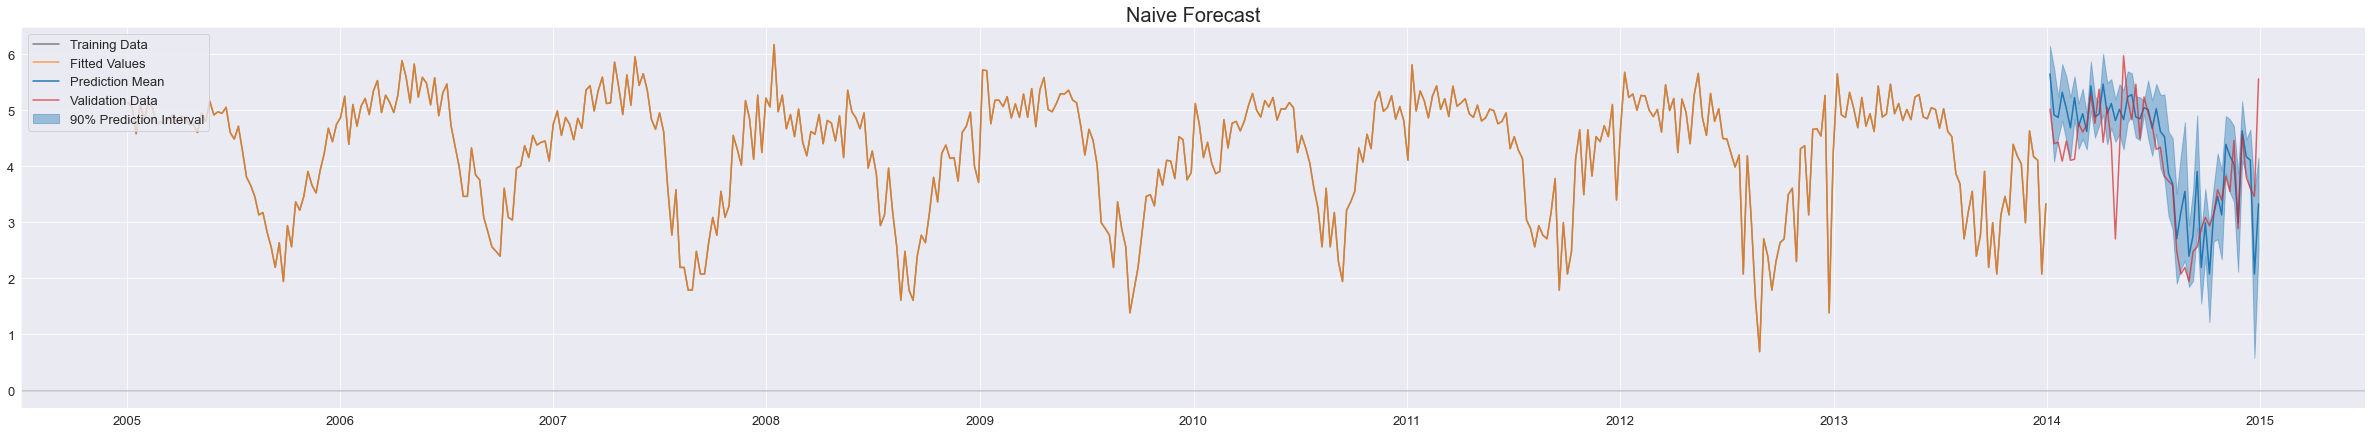

In [14]:
udf.plot_results(train,
                 val,
                 nv_fcst_mean,
                 nv_fcst_min,
                 nv_fcst_max,
                 train,
                 START, END, N_PERIODS, model_name)

[Naive Forecast]              	Bias:   0.22	Variance: 0.51  	MSE: 0.56  


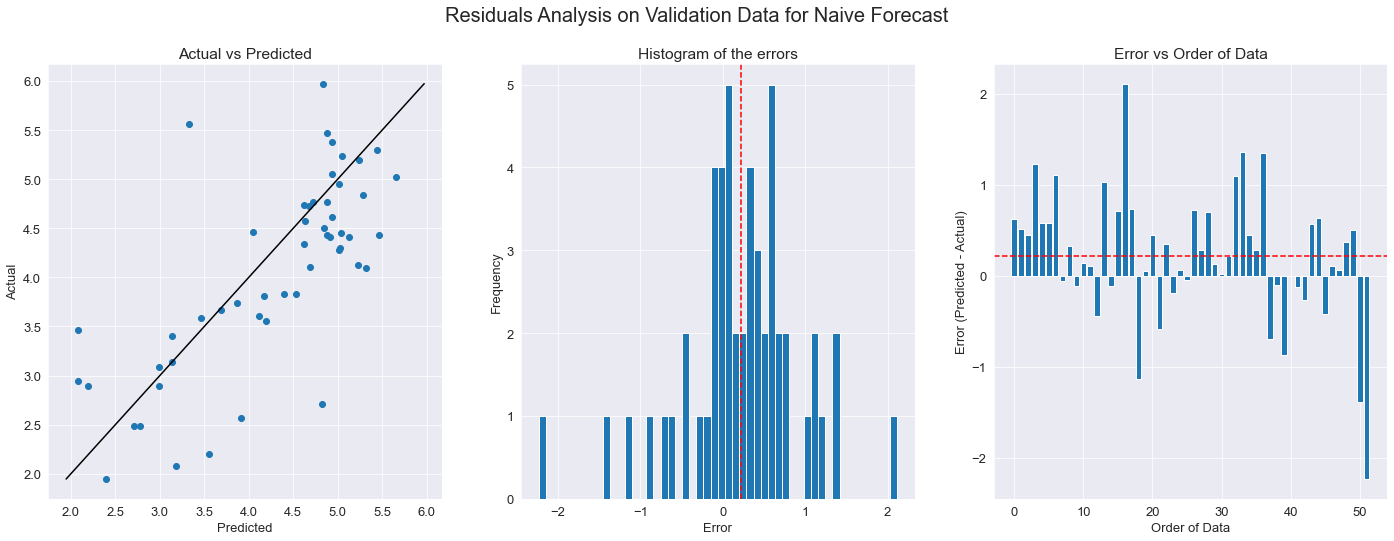

In [15]:
udf.var_bias_mse(nv_fcst_mean, val, model_name)
udf.valdata_plots(val, nv_fcst_mean, model_name)

The residuals from the naive forecast, when comparing the predicted data against the validation data, approximate a normal distribution and are homoscedastic. The naive forecast has done a good job.

## <a id='3.2'>3.2 Exponential Smoothing</a>

Exponential Smoothing (ES) is a family of time series methods related to "windowing" the time series - where recent observations are given greater weight than less recent observations. I consider the Holt-Winters (HW) multiplicative-additive ES method, which can accommodate seasonal data (additive) and trend data (multiplicative)<sup>2</sup>.

In [16]:
from statsmodels.tsa.api import ExponentialSmoothing
hwfit1 = ExponentialSmoothing(train, trend='mul', seasonal='add', damped_trend=True, seasonal_periods=52,  initialization_method="estimated").fit()
simulations = hwfit1.simulate(52, anchor=START, repetitions=100, random_errors='bootstrap') # For prediction interval

In [17]:
hw_fcst_mean, hw_fcst_min, hw_fcst_max = udf.prediction_intvl(hwfit1.forecast(52),simulations,True)

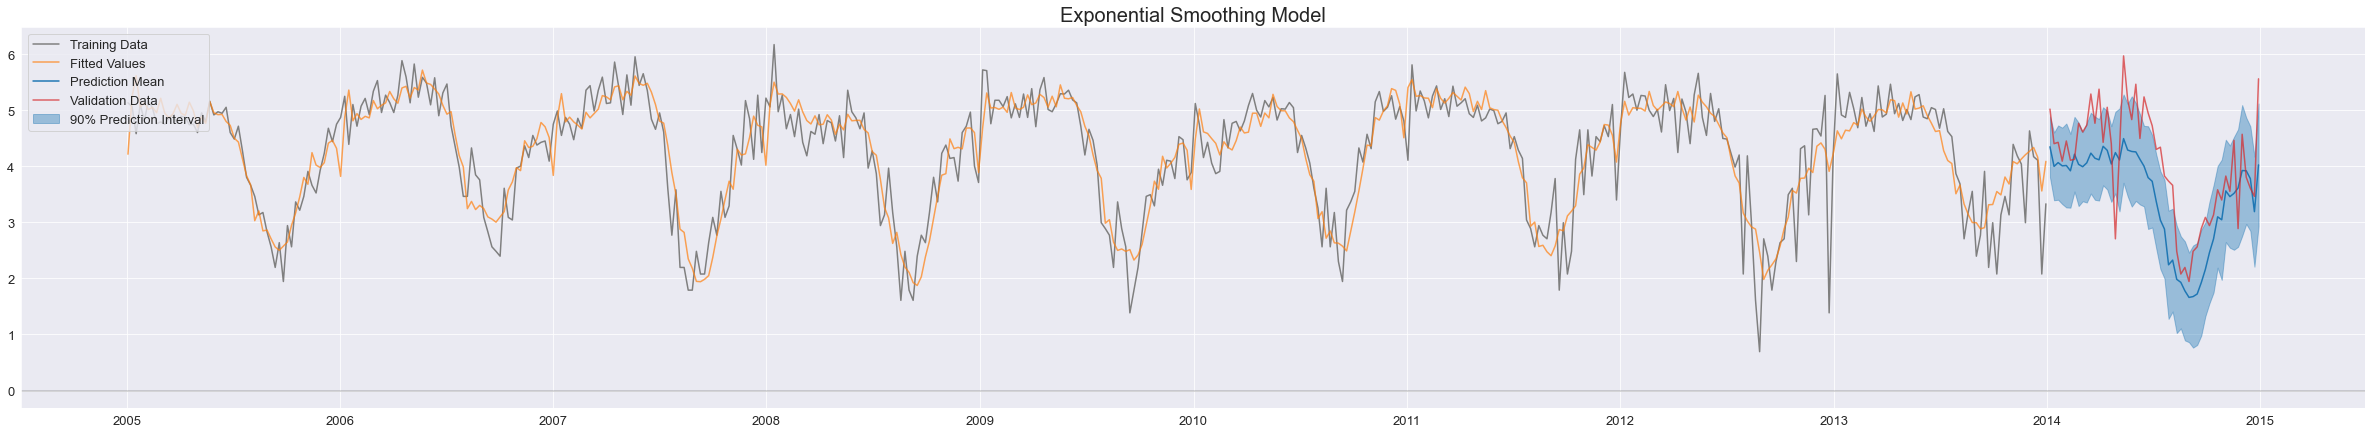

In [18]:
model_name = 'Exponential Smoothing Model'
udf.plot_results(train,
                 val,
                 hw_fcst_mean,
                 hw_fcst_min,
                 hw_fcst_max,
                 hwfit1.fittedvalues,
                 START, END, N_PERIODS, model_name)

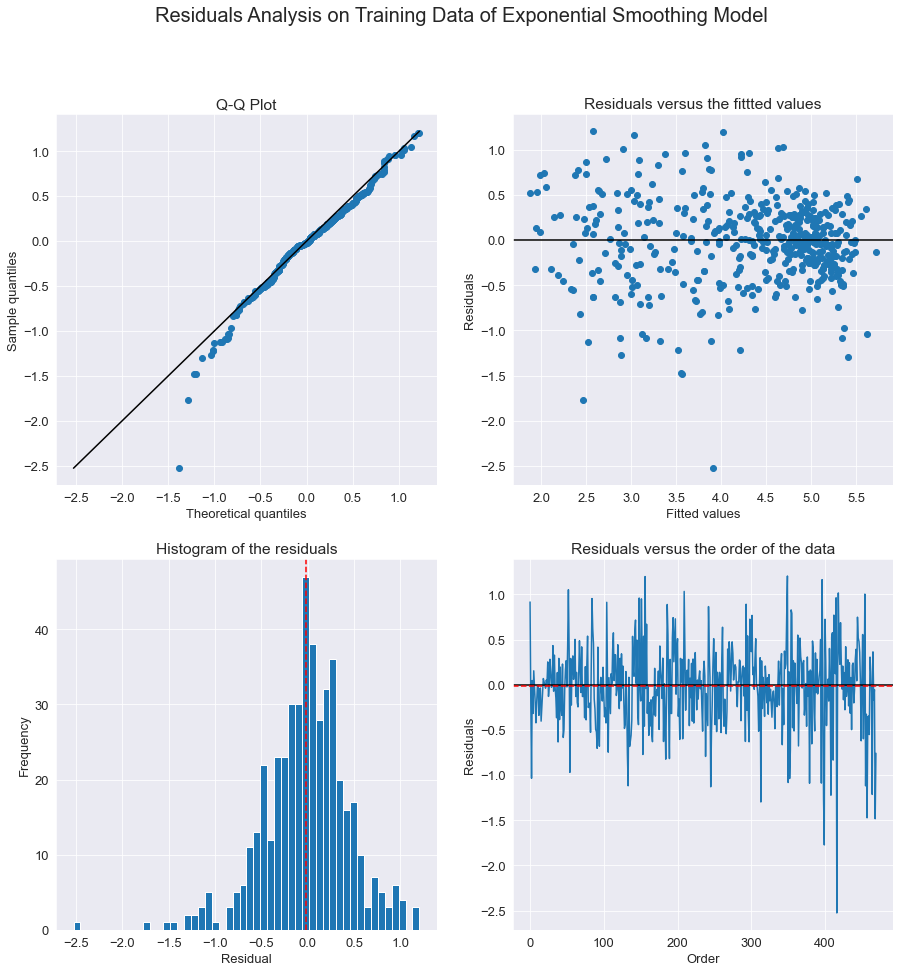

In [19]:
udf.residual_plots(hwfit1.resid,hwfit1.fittedvalues, model_name)

[Exponential Smoothing Model] 	Bias:  -0.58	Variance: 0.31  	MSE: 0.65  


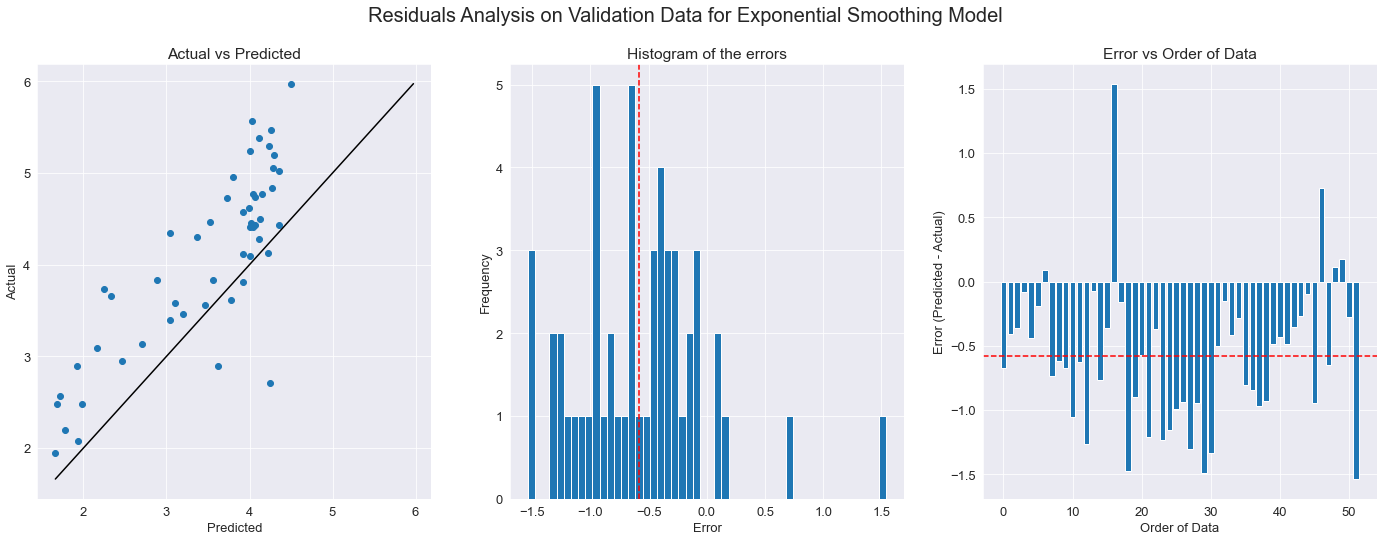

In [20]:
udf.var_bias_mse(hw_fcst_mean, val, model_name)
udf.valdata_plots(val, hw_fcst_mean, model_name)

Although the residuals do well on the training data, the performance is poor on the validation data - consistently undepredicting. To correct for this, if the bias term is added to the forecast values (+0.58) then the result is more acceptable. This is a workaround (fudge) for this validation dataset but not recommended as a method since the bias term could change for subsequent forecasts.

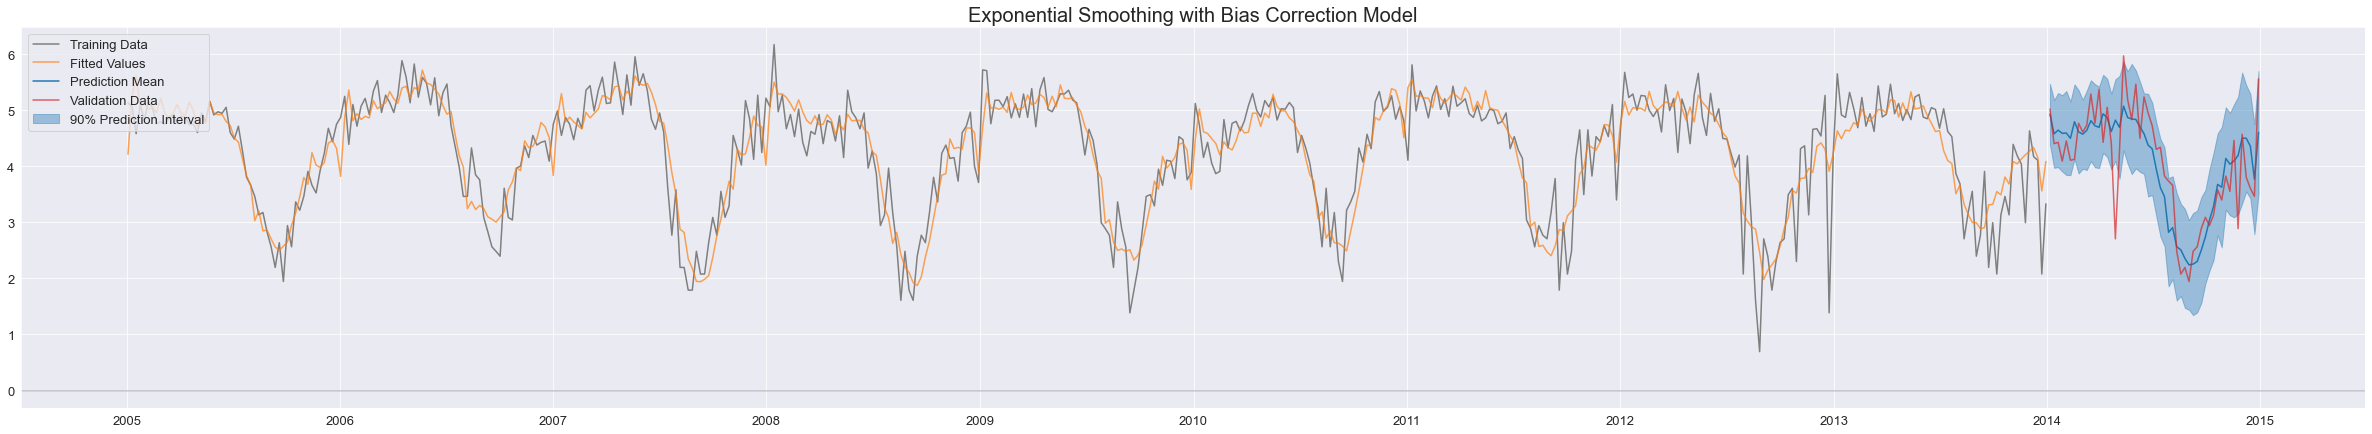

In [21]:
model_name = 'Exponential Smoothing with Bias Correction Model'
udf.plot_results(train,
                 val,
                 hw_fcst_mean+0.58,
                 hw_fcst_min+0.58,
                 hw_fcst_max+0.58,
                 hwfit1.fittedvalues,
                 START, END, N_PERIODS, model_name)

[Exponential Smoothing with Bias Correction Model]	Bias:  -0.00	Variance: 0.31  	MSE: 0.31  


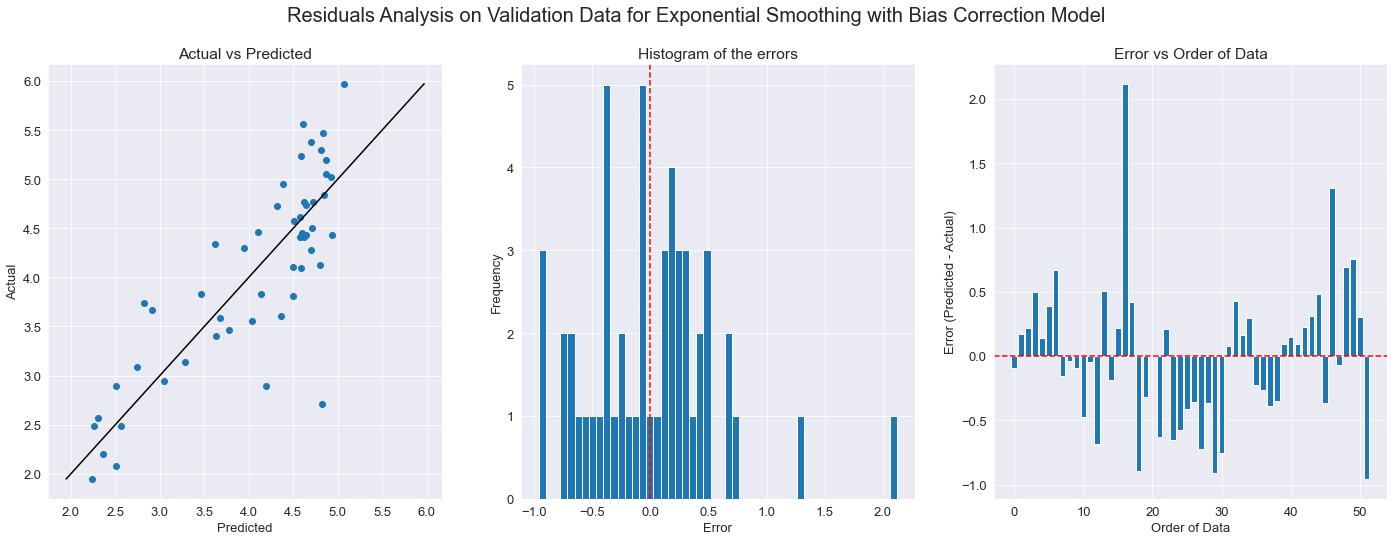

In [22]:
udf.var_bias_mse(hw_fcst_mean+0.58, val, model_name)
udf.valdata_plots(val, hw_fcst_mean+0.58, model_name)

## <a id='3.3'>3.3 STL Decomposition</a>

STL (Season-Trend decomposition using LOESS) separates the seasonal component from the trend component (trend-cycle componenet, to be specific). The trend component is therefore "seasonally adjusted". The time series model is then applied to this seasonally adjusted trend part and the forecast is made by predicting the next steps and recombined with the seasonal component.

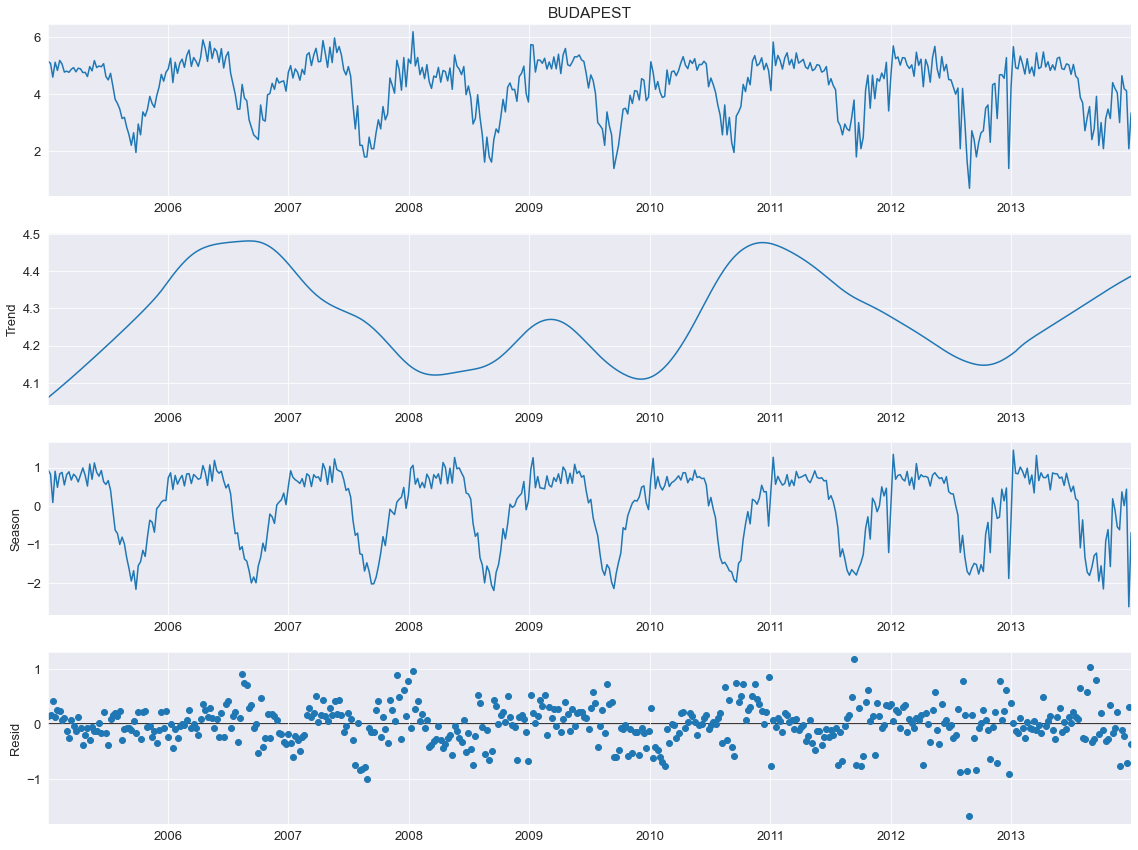

In [23]:
from statsmodels.tsa.seasonal import STL
stl = STL(train, period = 52, robust = False)
stlfit = stl.fit()
plt.rc('figure',figsize=(16,12))
stlfit.plot();

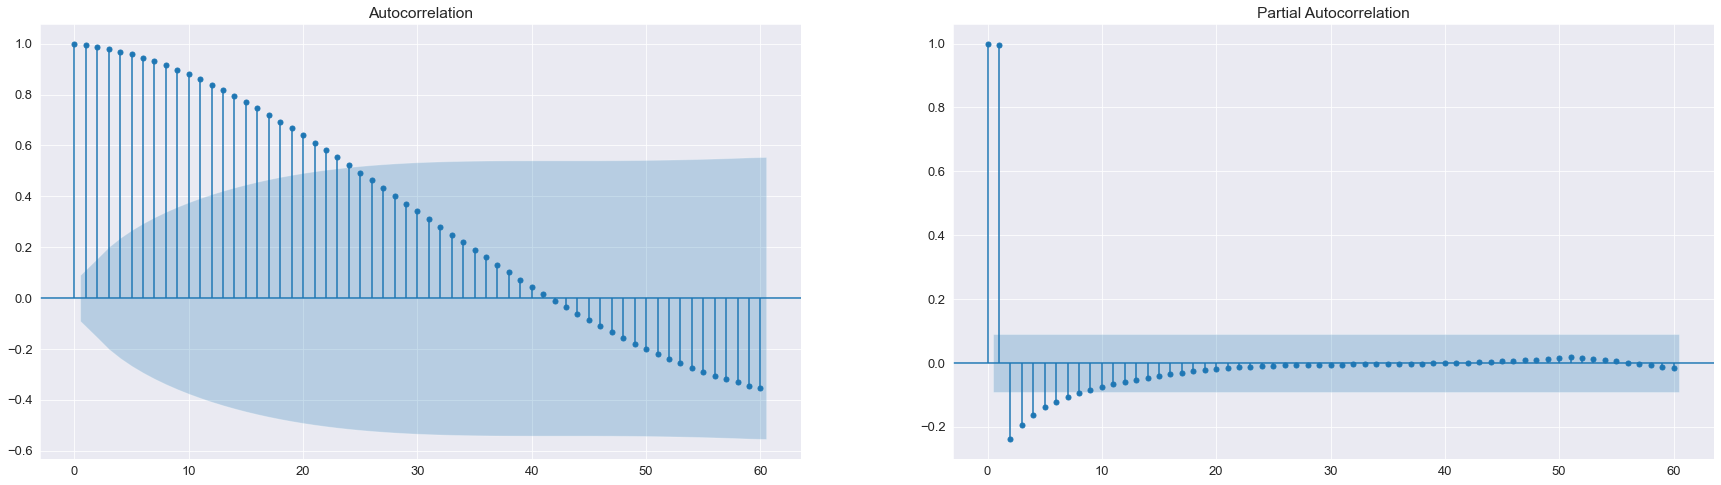

In [24]:
# ACF & PACF Plots of the Trend Component
udf.acf_pacf_plots(stlfit.trend,0,60)

The ACF plot of the trend points to an Auto Regressive (AR) model. The PACF plot suggests this AR model is of order 1 (spike at lag 1 which disappears).

In [25]:
# Build Model for trend-cycle component after decomposition using STL
stlf = STLForecast(train.squeeze(), ARIMA, model_kwargs=dict(order=(1,0,1), trend='n', enforce_invertibility=False))
stlf_fit = stlf.fit()
stfl_forecast = stlf_fit.get_prediction(start=START,end=END)
model_name = 'STL x ARIMA Model'

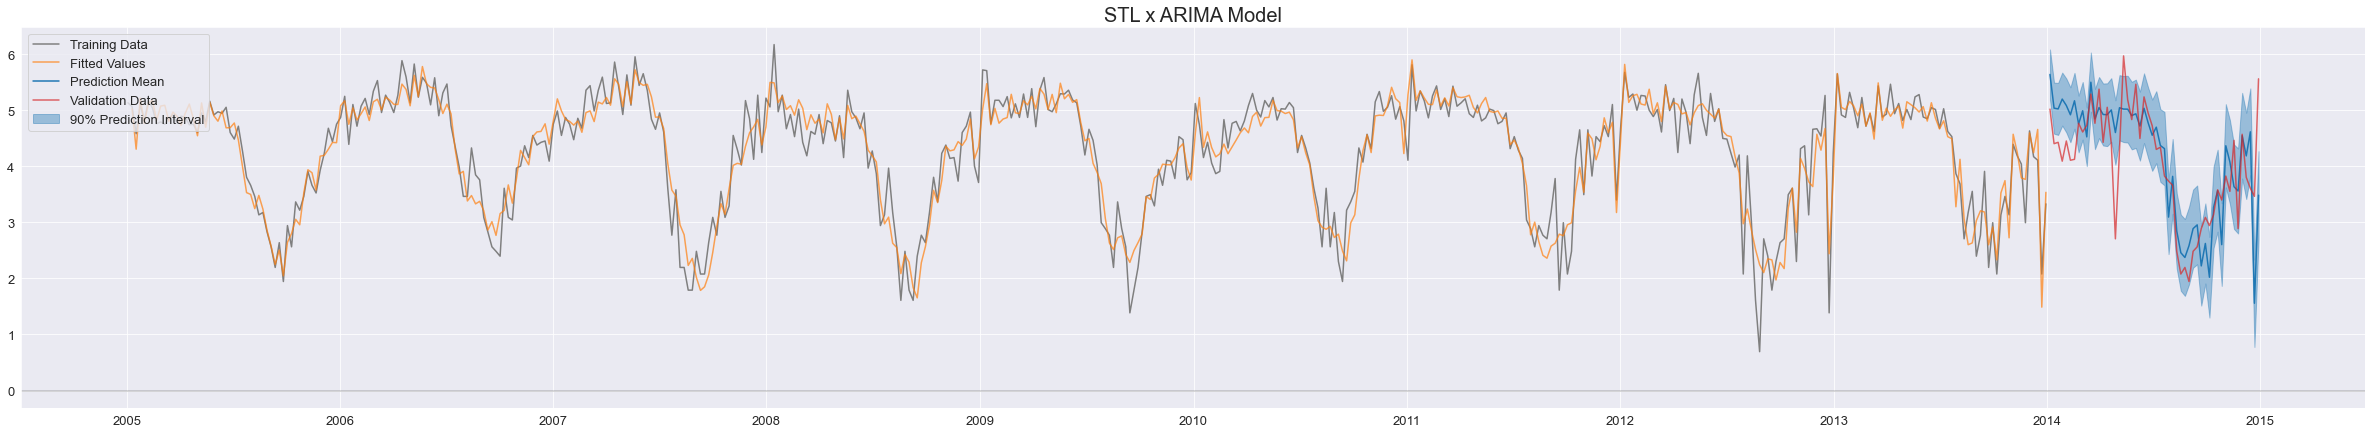

In [26]:
stfl_fcst_mean, stfl_fcst_min, stfl_fcst_max = udf.prediction_intvl(stfl_forecast,None,False)
udf.plot_results(train,
             val,
             stfl_fcst_mean,
             stfl_fcst_min,
             stfl_fcst_max,
             (stlf_fit.model_result.fittedvalues + stlf_fit.result.seasonal)[1:],
             START, END, N_PERIODS, model_name)

In [27]:
print(stlf_fit.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                  470
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -175.385
Date:                Thu, 29 Jul 2021   AIC                            356.770
Time:                        19:23:03   BIC                            369.228
Sample:                    01-03-2005   HQIC                           361.671
                         - 12-30-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   8427.052      0.000       1.000       1.000
ma.L1         -0.7969      0.023    -33.913      0.000      -0.843      -0.751
sigma2         0.1216      0.006     19.748      0.0

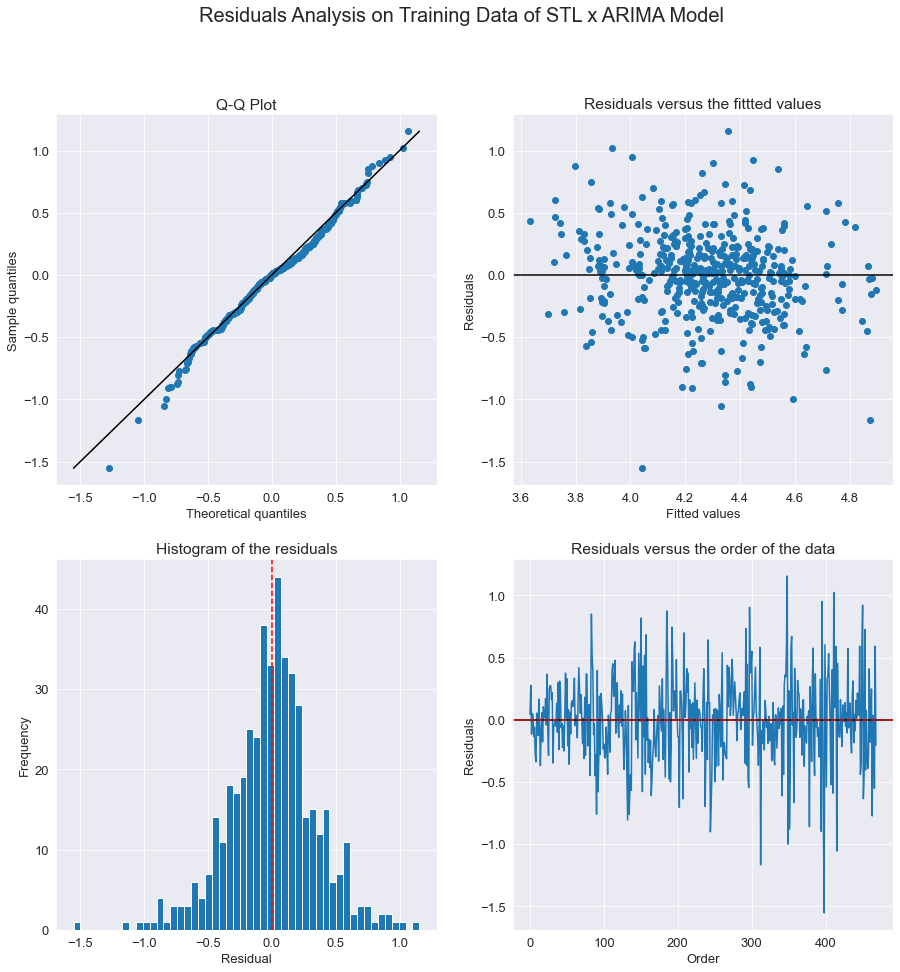

In [28]:
udf.residual_plots(stlf_fit.model_result.resid[1:],stlf_fit.model_result.fittedvalues[1:], model_name)

[STL x ARIMA Model]           	Bias:   0.11	Variance: 0.49  	MSE: 0.50  


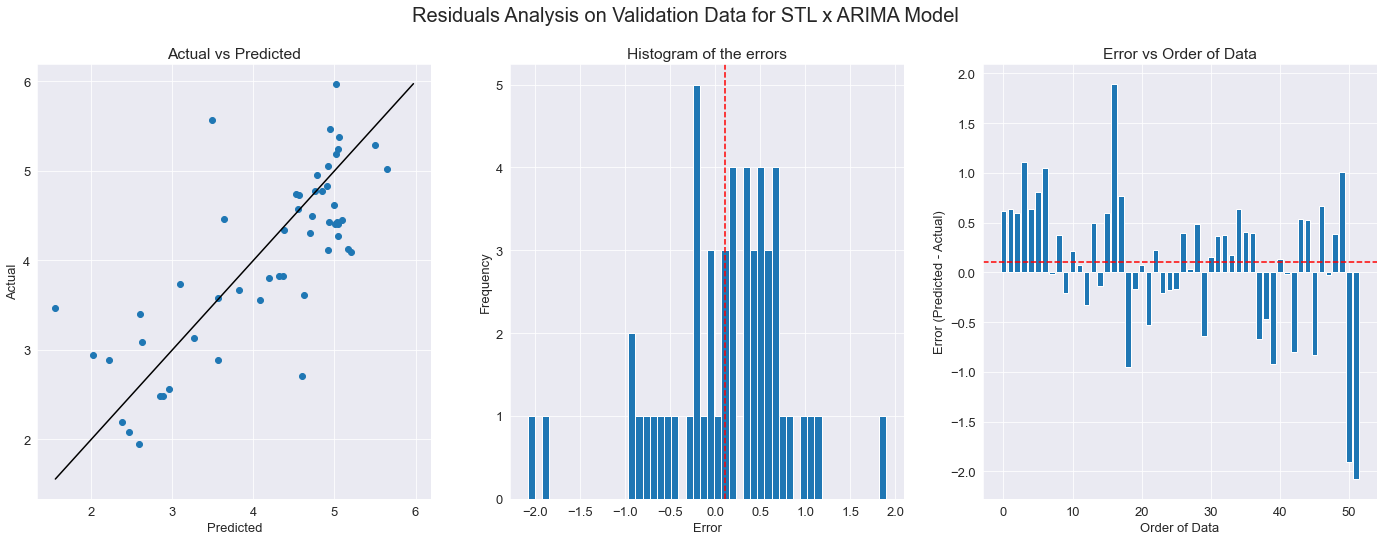

In [29]:
udf.var_bias_mse(stfl_fcst_mean, val, model_name)
udf.valdata_plots(val, stfl_fcst_mean, model_name)

The residuals on the training data and the errors on the validation data suggest the model is a good fit. In addition, The bias, variance, and MSE are "better" than the naive forecast. However, this forecast has larger errors at the end of the forecast period compared to the naive forecast - which could be problematic.

## <a id='3.4'>3.4 SARIMA</a>

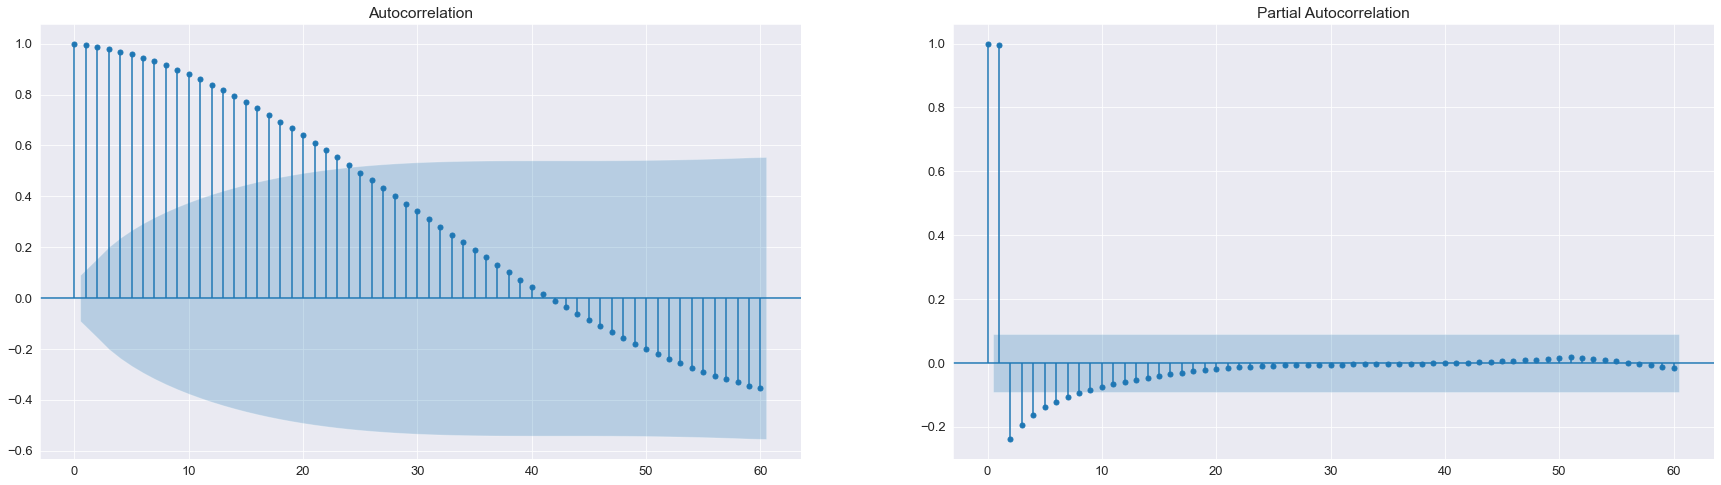

In [30]:
udf.acf_pacf_plots(stlfit.trend,0, 60)

The spike at lag 1 on the PACF for the trend-cycle component suggests that the auto correlations in the ACF plot are a result on an underlying AR(1) model (they propogate through).

In [31]:
# SARIMA(X) Model
sarima_mod = sm.tsa.statespace.SARIMAX(train, order=(1,0,0), trend = 'n', seasonal_order = (0,1,1,52))
sarima_fit = sarima_mod.fit(disp=False, outer_iter=400)
sarima_forecast = sarima_fit.get_prediction(start=START,end=END)
sarima_fcst_mean, sarima_fcst_min, sarima_fcst_max = udf.prediction_intvl(sarima_forecast,None,False)

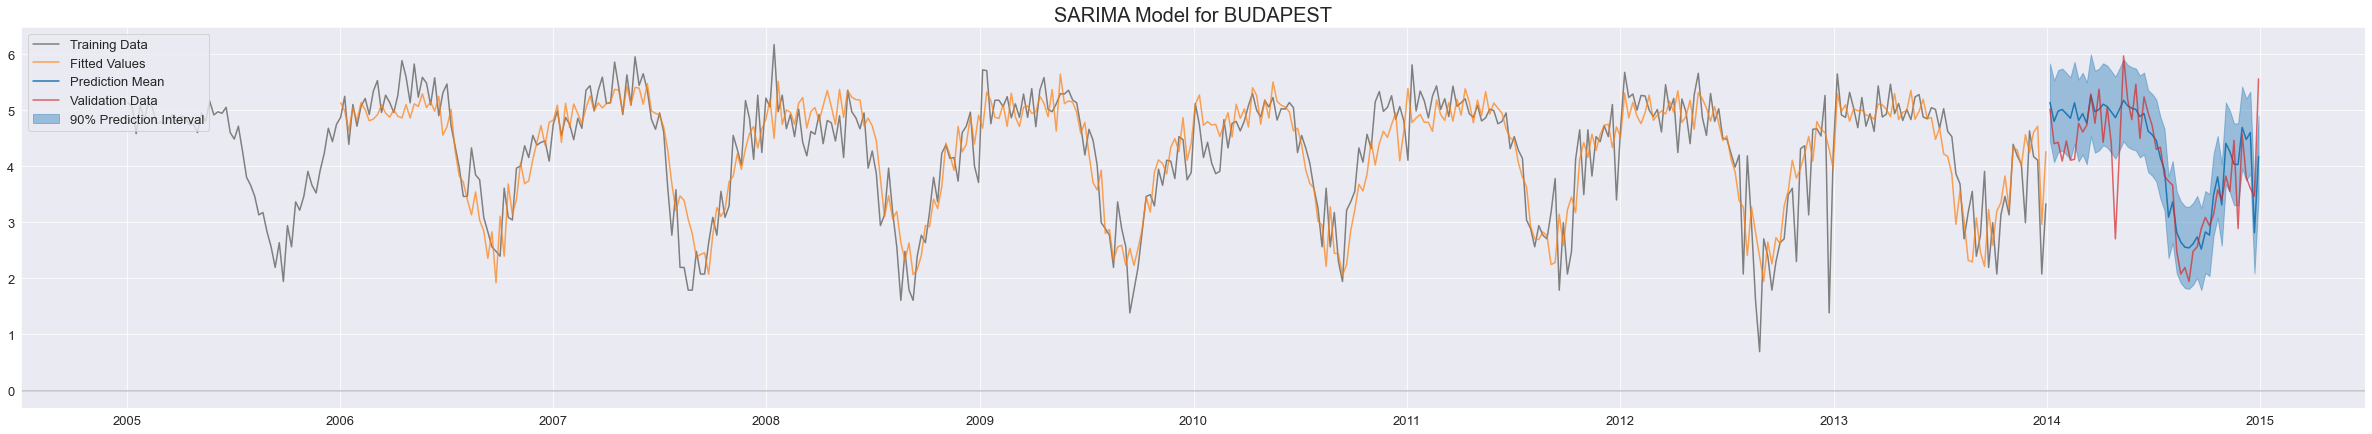

In [32]:
model_name = 'SARIMA Model for BUDAPEST'
udf.plot_results(train,
             val,
             sarima_fcst_mean,
             sarima_fcst_min,
             sarima_fcst_max,
             sarima_fit.fittedvalues[N_PERIODS:],
             START, END, N_PERIODS, model_name)

In [33]:
print(sarima_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             BUDAPEST   No. Observations:                  470
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 52)   Log Likelihood                -353.324
Date:                              Thu, 29 Jul 2021   AIC                            712.649
Time:                                      19:23:09   BIC                            724.755
Sample:                                  01-03-2005   HQIC                           717.434
                                       - 12-30-2013                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3062      0.038      7.995      0.000       0.231       0.381
ma.S.L52      -0.66

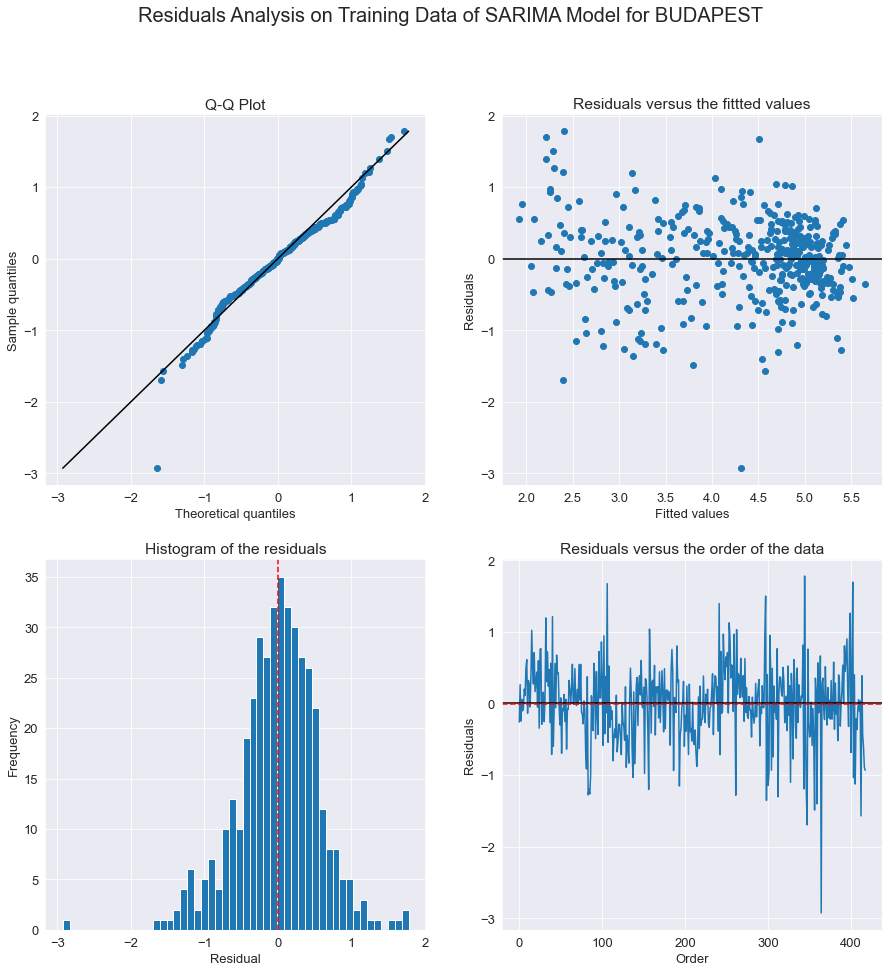

In [34]:
udf.residual_plots(sarima_fit.resid[N_PERIODS:],sarima_fit.fittedvalues[N_PERIODS:], model_name)

[SARIMA Model for BUDAPEST]   	Bias:   0.19	Variance: 0.33  	MSE: 0.36  


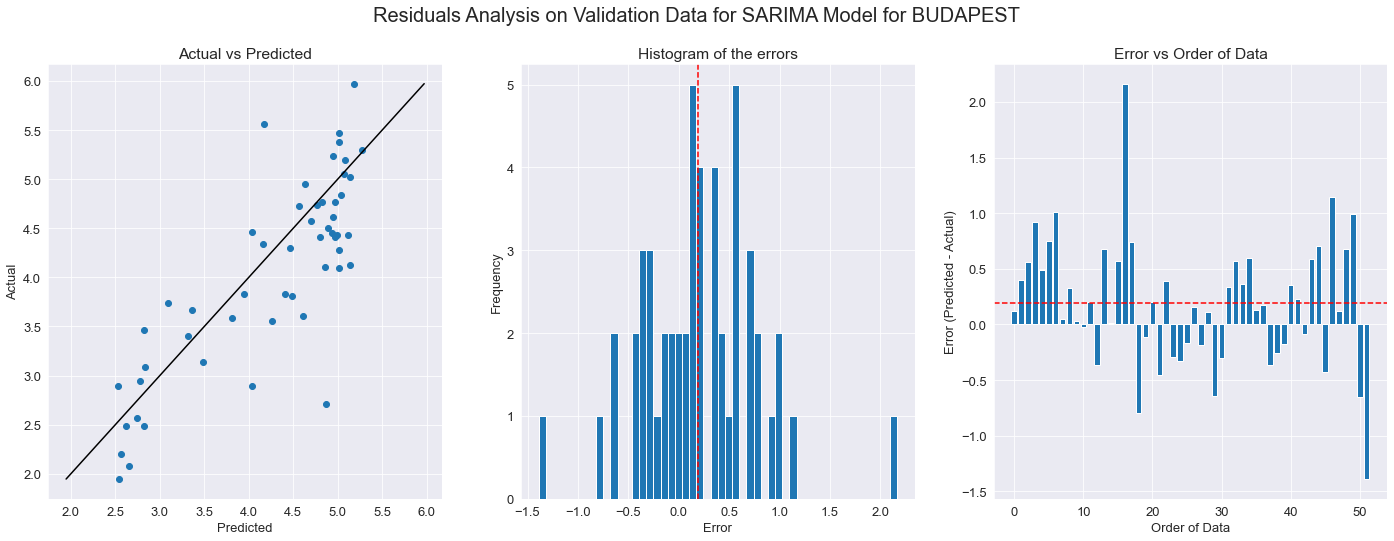

In [35]:
udf.var_bias_mse(sarima_fcst_mean, val, model_name)
udf.valdata_plots(val, sarima_fcst_mean, model_name)

## <a id='3.5'>3.5 Univariate Summary</a>

Both the STL and SARIMA models "beat" the Naive Forecast with respect to bias and variance so there is "value" added to implementing a more statistical forecast (however, this also needs to be balanced with time, money, and knowledge to implement a statistical forecast vs a naive forecast - little specific knowledge to implement - so it might not be adding value overall, I won't consider the time/money/knowledge tradeoff here though). The Exponential Smoothing performed poorly and will be discarded.

Between the STL and SARIMA models themselves there is a bias and variance tradeoff. The STL model has lower bias than the SARIMA model but the SARIMA model has lower variance versus the STL model. On balance, I would go with the SARIMA model (lower MSE, fewer lines of code) over the STL model.

# <a id='4.0'>4. Multivariate Time Series</a>

I shall now implement multivariate series analysis so as to predict the chickenpox series on the whole dataset using three methods:
1. Naive Forecast on each univariate series.
2. Vector Autogression Model (VAR) on the multivariate series.

Methods 2) is truly multivariate in nature, whereas 1) is applying a univariate method to each series. With each method, I shall build a nationwide series too (using a bottom-up approach. A top-down approach could be implemented but my starting position is county to nation, rather than the other way. Each has its pros/cons. With a bottom-up approach errors could be big at the nationwide level, with a top-down level, the county level prediction could be underpredicting).

In [36]:
all_train, all_val = udf.train_test_split(np.log(data_df+2), N_PERIODS) # Transform
all_train['HUNGARY'] = all_train.sum(axis=1)
all_val['HUNGARY'] = all_val.sum(axis=1)

## <a id='4.1'>4.1 Naive Forecast</a>

In [37]:
all_nv_fcst_mean_dict = {}
all_nv_fcst_min_dict = {}
all_nv_fcst_max_dict = {}
for county in data_df.columns:
    data = data_df[county]
    data = np.log(data+2) # Transfrom
    train, val = udf.train_test_split(data, N_PERIODS) # Split into train and validation
    model_name = 'Naive Forecast for ' + county # Set model name
    nv_predictions = train[-N_PERIODS:] # Make Naive Forecast    
    nv_fcst_mean, nv_fcst_min, nv_fcst_max = udf.nv_pred_intvl(nv_predictions, val, train) # Get Mean and Prediction Intervals
    all_nv_fcst_mean_dict[county] = nv_fcst_mean # Add mean to dict
    all_nv_fcst_min_dict[county] = nv_fcst_min # Add min to dict
    all_nv_fcst_max_dict[county] = nv_fcst_max # Add max to dict
    udf.var_bias_mse(nv_fcst_mean, val, model_name) # Evaluation
# Make DF from Dict
total_nv_fc_mean = pd.DataFrame(all_nv_fcst_mean_dict)
total_nv_fc_min = pd.DataFrame(all_nv_fcst_min_dict)
total_nv_fc_max = pd.DataFrame(all_nv_fcst_max_dict)
# Add Nationwide Column
total_nv_fc_mean['HUNGARY'] = total_nv_fc_mean.sum(axis=1)
total_nv_fc_min['HUNGARY'] = total_nv_fc_min.sum(axis=1)
total_nv_fc_max['HUNGARY'] = total_nv_fc_max.sum(axis=1)

[Naive Forecast for BUDAPEST] 	Bias:   0.22	Variance: 0.51  	MSE: 0.56  
[Naive Forecast for BARANYA]  	Bias:   0.47	Variance: 0.81  	MSE: 1.03  
[Naive Forecast for BACS]     	Bias:  -0.22	Variance: 1.42  	MSE: 1.47  
[Naive Forecast for BEKES]    	Bias:   0.19	Variance: 1.45  	MSE: 1.48  
[Naive Forecast for BORSOD]   	Bias:   0.31	Variance: 0.99  	MSE: 1.08  
[Naive Forecast for CSONGRAD] 	Bias:  -0.08	Variance: 2.32  	MSE: 2.33  
[Naive Forecast for FEJER]    	Bias:  -0.07	Variance: 0.96  	MSE: 0.97  
[Naive Forecast for GYOR]     	Bias:   0.34	Variance: 0.80  	MSE: 0.92  
[Naive Forecast for HAJDU]    	Bias:   0.41	Variance: 0.90  	MSE: 1.07  
[Naive Forecast for HEVES]    	Bias:   0.13	Variance: 1.75  	MSE: 1.77  
[Naive Forecast for JASZ]     	Bias:  -0.17	Variance: 1.11  	MSE: 1.14  
[Naive Forecast for KOMAROM]  	Bias:  -0.18	Variance: 1.25  	MSE: 1.28  
[Naive Forecast for NOGRAD]   	Bias:   0.42	Variance: 1.03  	MSE: 1.20  
[Naive Forecast for PEST]     	Bias:   0.05	Varianc

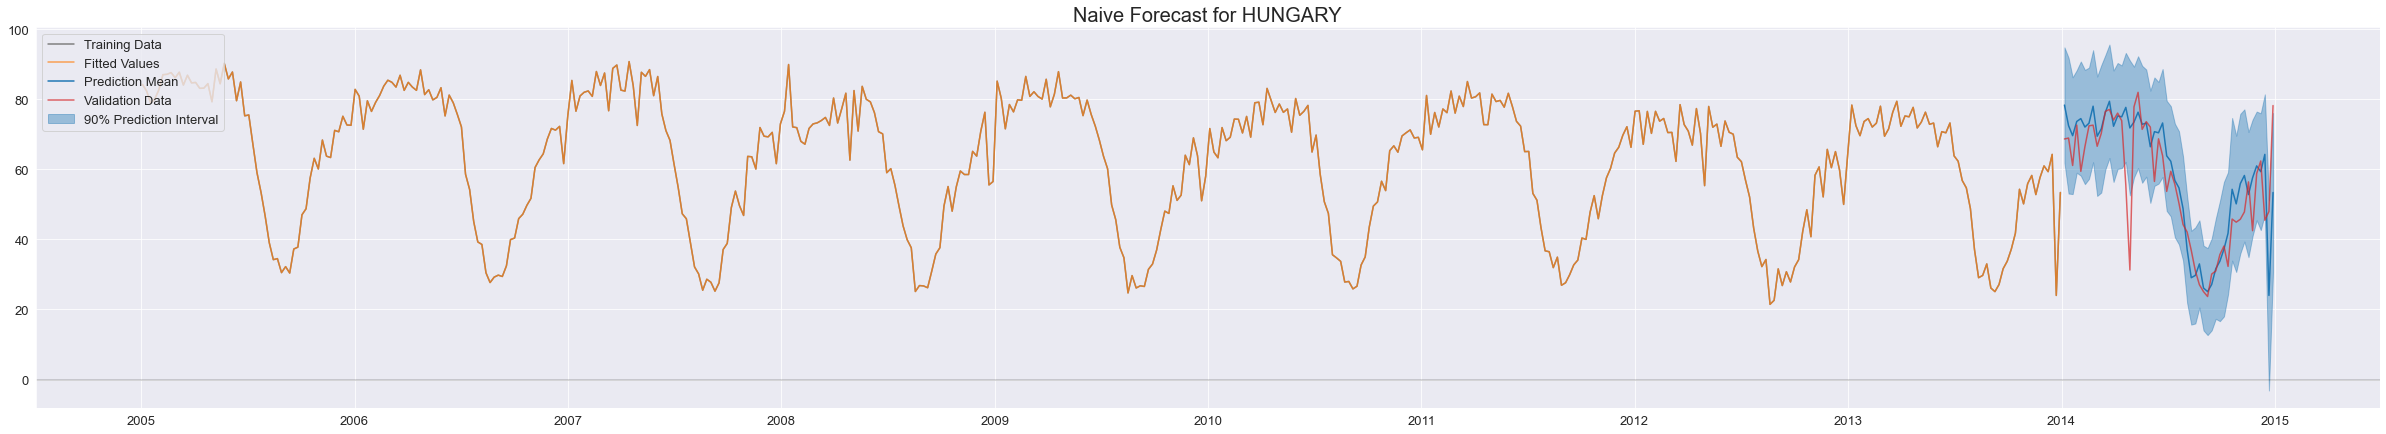

[Naive Forecast for HUNGARY]  	Bias:   3.16	Variance: 95.69 	MSE: 105.67


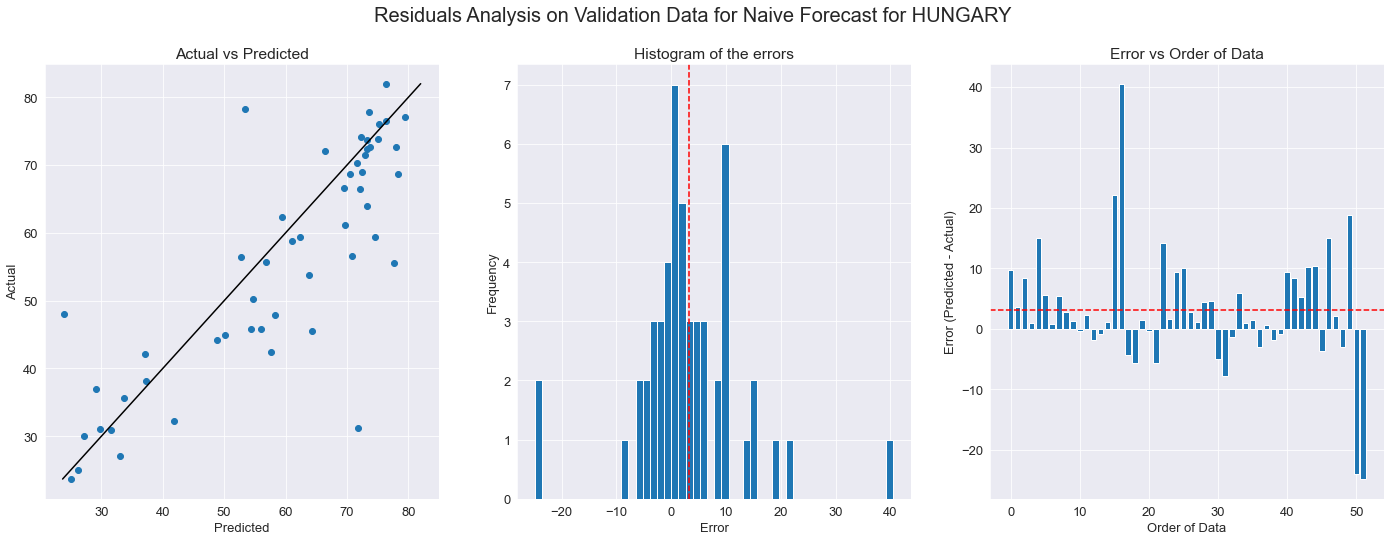

In [38]:
model_name = 'Naive Forecast for HUNGARY'
# Plot Hungary Total
udf.plot_results(all_train['HUNGARY'],
                 all_val['HUNGARY'], 
                 total_nv_fc_mean['HUNGARY'],
                 total_nv_fc_min['HUNGARY'],
                 total_nv_fc_max['HUNGARY'],
                 all_train['HUNGARY'],
                 START, END, N_PERIODS, model_name)
udf.var_bias_mse(total_nv_fc_mean['HUNGARY'], all_val['HUNGARY'], model_name)
udf.valdata_plots(all_val['HUNGARY'], total_nv_fc_mean['HUNGARY'], model_name)

## <a id='4.2'>4.2 Vector Auto Regression (VAR)</a>

In [39]:
var_model = VAR(all_train.drop(columns='HUNGARY'))
results = var_model.fit(maxlags=5, ic='aic')
#results.summary() # Comment to suppress summary results

In [40]:
lag_order = results.k_ar
print(f'VAR model of order {lag_order}')

VAR model of order 2


In [41]:
var_fcst_mean = pd.DataFrame(results.forecast_interval(all_train.drop(columns='HUNGARY').values[-lag_order:], 52)[0], index=all_val.index, columns=all_train.drop(columns='HUNGARY').columns)
var_fcst_min = pd.DataFrame(results.forecast_interval(all_train.drop(columns='HUNGARY').values[-lag_order:], 52)[1], index=all_val.index, columns=all_train.drop(columns='HUNGARY').columns)
var_fcst_max = pd.DataFrame(results.forecast_interval(all_train.drop(columns='HUNGARY').values[-lag_order:], 52)[2], index=all_val.index, columns=all_train.drop(columns='HUNGARY').columns)

In [42]:
var_fcst_mean['HUNGARY'] = var_fcst_mean.sum(axis=1)
var_fcst_min['HUNGARY'] = var_fcst_min.sum(axis=1)
var_fcst_max['HUNGARY'] = var_fcst_max.sum(axis=1)

[VAR Model for BUDAPEST]      	Bias:   0.11	Variance: 1.00  	MSE: 1.01  
[VAR Model for BARANYA]       	Bias:   0.19	Variance: 1.01  	MSE: 1.05  
[VAR Model for BACS]          	Bias:   0.20	Variance: 1.94  	MSE: 1.98  
[VAR Model for BEKES]         	Bias:   0.39	Variance: 1.50  	MSE: 1.66  
[VAR Model for BORSOD]        	Bias:   0.31	Variance: 2.00  	MSE: 2.09  
[VAR Model for CSONGRAD]      	Bias:   0.14	Variance: 2.13  	MSE: 2.15  
[VAR Model for FEJER]         	Bias:   0.23	Variance: 1.04  	MSE: 1.09  
[VAR Model for GYOR]          	Bias:   0.36	Variance: 1.08  	MSE: 1.21  
[VAR Model for HAJDU]         	Bias:   0.36	Variance: 1.53  	MSE: 1.66  
[VAR Model for HEVES]         	Bias:   0.23	Variance: 1.64  	MSE: 1.69  
[VAR Model for JASZ]          	Bias:  -0.16	Variance: 0.80  	MSE: 0.83  
[VAR Model for KOMAROM]       	Bias:   0.42	Variance: 0.92  	MSE: 1.09  
[VAR Model for NOGRAD]        	Bias:   0.34	Variance: 1.12  	MSE: 1.23  
[VAR Model for PEST]          	Bias:   0.08	Varianc

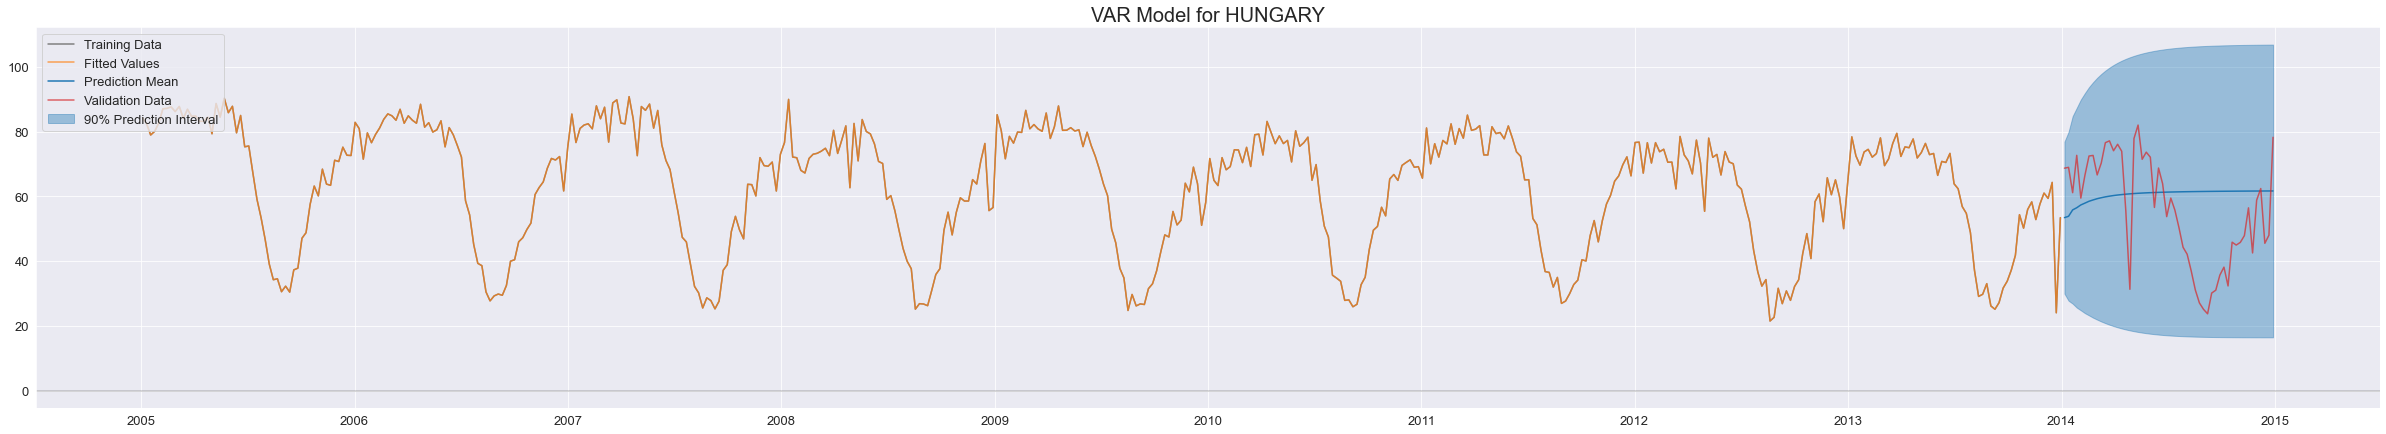

In [43]:
for county_n in var_fcst_mean.columns:
    model_name = 'VAR Model for %s' % (county_n)
    if county_n != 'HUNGARY':      
        udf.var_bias_mse(var_fcst_mean[county_n], all_val[county_n], model_name)
    if county_n == 'HUNGARY':
        udf.plot_results(all_train[county_n],
                         all_val[county_n], 
                         var_fcst_mean[county_n],
                         var_fcst_min[county_n],
                         var_fcst_max[county_n],
                         all_train[county_n], 
                         START, END, N_PERIODS, model_name)

[VAR for HUNGARY]             	Bias:   4.62	Variance: 307.53	MSE: 328.85


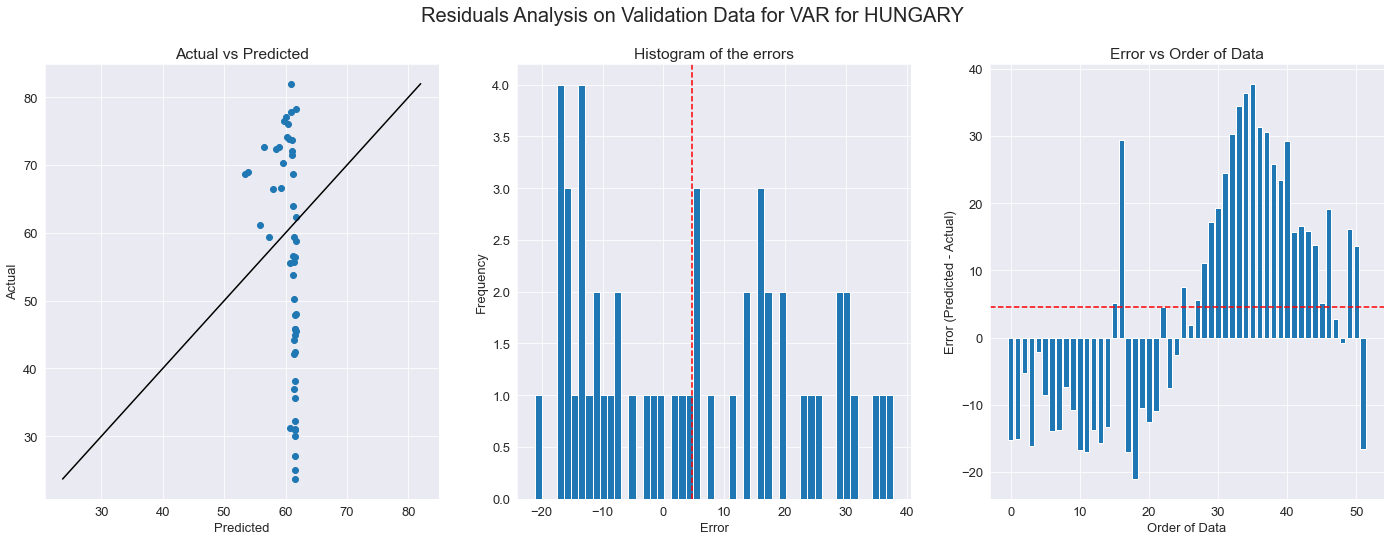

In [44]:
udf.var_bias_mse(var_fcst_mean['HUNGARY'], all_val['HUNGARY'], 'VAR for HUNGARY')
udf.valdata_plots(all_val['HUNGARY'], var_fcst_mean['HUNGARY'], 'VAR for HUNGARY')

The VAR model (of order 2), although having a low bias for individual counties, has a large bias for the national level and does a poor job capturing seasonal effects (as expected from a VAR model) and this is reflected in the large prediction intervals.

# <a id='5.0'>5. Summary</a>
Concerning the forecasting methods, a **SARIMA model** for each univariate series would produce the "best predictions" (using MSE and capturing seasonality). Second best would be a naive forecast (time and cost to implement a SARIMA model must also be taken into consideration vs a naive forecast). 

# References

1. How to Best Understand the Naive Forecast. Brightwork Research & Analysis. https://www.brightworkresearch.com/naive-forecast/.
2. Holt-Winters’ seasonal method | Forecasting: Principles and Practice (2nd ed). (n.d.). https://otexts.com/fpp2/holt-winters.html

* Dataset: Hungarian Chickenpox Cases Data Set from UCI Machine Learning Repository https://archive.ics.uci.edu/ml/datasets/Hungarian+Chickenpox+Cases